Depedencies

In [1]:
import torch
import torchvision
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import transforms as T
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Explore csv

In [ ]:
import pandas as pd

image_folder = '/content/drive/MyDrive/new_machine/downsampled_resized_images'
csv_path = '/content/drive/MyDrive/new_machine/transformed_bounding_boxes.csv'
df = pd.read_csv(csv_path)

# Display basic info about the dataset
print(df.head())
print(df.info())
print(df['class'].value_counts())  # Check class distribution

             NAME   x1   y1   x2   y2 class  fixed_border
0  fbe43c89-f.jpg  124  119  231  238     B         False
1  05e1b04d-b.jpg   97  107  256  252     B         False
2  7b343680-c.jpg  102  112  247  250     B         False
3  4781943b-8.jpg  115  113  241  273     B         False
4  e51e30ca-f.jpg  110  137  242  269     B         False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13798 entries, 0 to 13797
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   NAME          13798 non-null  object
 1   x1            13798 non-null  int64 
 2   y1            13798 non-null  int64 
 3   x2            13798 non-null  int64 
 4   y2            13798 non-null  int64 
 5   class         13798 non-null  object
 6   fixed_border  13798 non-null  bool  
dtypes: bool(1), int64(4), object(2)
memory usage: 660.4+ KB
None
class
B           600
LyB         600
SS          600
PNN         600
PM          600
MoB         60

In [ ]:
df.shape

(13798, 7)

In [ ]:
df.isna().sum()

,0
NAME,0
x1,0
y1,0
x2,0
y2,0
class,0
fixed_border,0


In [ ]:
df.drop('fixed_border', inplace=True, axis=1)
df.head()

,NAME,x1,y1,x2,y2,class
0,fbe43c89-f.jpg,124,119,231,238,B
1,05e1b04d-b.jpg,97,107,256,252,B
2,7b343680-c.jpg,102,112,247,250,B
3,4781943b-8.jpg,115,113,241,273,B
4,e51e30ca-f.jpg,110,137,242,269,B


In [ ]:
df.columns

Index(['NAME', 'x1', 'y1', 'x2', 'y2', 'class'], dtype='object')

Check csv and images folder coincidence

In [ ]:
image_filenames = set(os.listdir(image_folder))  # List all image files in the folder
excel_filenames = set(df['NAME'])  # Get the list of image filenames from the Excel sheet

# Missing images
missing_images = excel_filenames - image_filenames  # Files in the Excel but not in the folder
print(f"Missing images: {len(missing_images)}")  # Print the count of missing images

# Extra images
extra_images = image_filenames - excel_filenames  # Files in the folder but not in the Excel
print(f"Extra images: {len(extra_images)}")  # Print the count of extra images

**___________________________________________________________________________**
**___________________________________________________________________________**
**___________________________________________________________________________**
**___________________________________________________________________________**
**___________________________________________________________________________**
**___________________________________________________________________________**
**___________________________________________________________________________**

COCO format

In [ ]:
def convert_to_coco_format(df, image_dir, output_path):
    # COCO structure
    coco = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Create a mapping for class names to category IDs
    class_names = sorted(df['class'].unique())  # Ensure consistent ordering
    class_mapping = {class_name: idx + 1 for idx, class_name in enumerate(class_names)}  # Start IDs from 1

    # Add categories to COCO
    for class_name, class_id in class_mapping.items():
        coco["categories"].append({
            "id": class_id,
            "name": class_name,
            "supercategory": "none"
        })

    annotation_id = 1  # Unique annotation ID
    image_ids = {}  # To ensure unique image IDs

    for idx, row in df.iterrows():
        image_name = row['NAME']
        img_path = os.path.join(image_dir, image_name)

        # Read the image to get dimensions
        img = cv2.imread(img_path)
        if img is None:
            print(f"Image {image_name} not found. Skipping.")
            continue

        height, width = img.shape[:2]

        # Add the image entry
        if image_name not in image_ids:
            image_id = len(image_ids) + 1
            image_ids[image_name] = image_id
            coco["images"].append({
                "id": image_id,
                "file_name": image_name,
                "width": width,
                "height": height
            })

        # Convert bounding box [x1, y1, x2, y2] to [x, y, width, height]
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        bbox = [x1, y1, x2 - x1, y2 - y1]

        # Add the annotation entry
        coco["annotations"].append({
            "id": annotation_id,
            "image_id": image_ids[image_name],
            "category_id": class_mapping[row['class']],
            "bbox": bbox,
            "area": bbox[2] * bbox[3],  # width * height
            "iscrowd": 0  # Set to 0 for individual objects
        })

        annotation_id += 1

    # Save to JSON file
    with open(output_path, 'w') as f:
        json.dump(coco, f, indent=4)

    print(f"COCO format annotations saved to {output_path}")

In [ ]:
from sklearn.model_selection import train_test_split

# Group by image name
grouped = df.groupby('NAME')

# Extract unique image names
unique_images = list(grouped.groups.keys())

# Split by image name
train_images, temp_images = train_test_split(unique_images, test_size=0.3, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

# Filter the original dataset based on the splits
train_df = df[df['NAME'].isin(train_images)]
val_df = df[df['NAME'].isin(val_images)]
test_df = df[df['NAME'].isin(test_images)]

# Save paths for train, validation, and test COCO JSON files
train_output_path = '/content/drive/MyDrive/new_machine/coco_train_new.json'
val_output_path = '/content/drive/MyDrive/new_machine/coco_val_new.json'
test_output_path = '/content/drive/MyDrive/new_machine/coco_test_new.json'

# Convert train, validation, and test DataFrames to COCO format
convert_to_coco_format(train_df, image_folder, train_output_path)
convert_to_coco_format(val_df, image_folder, val_output_path)
convert_to_coco_format(test_df, image_folder, test_output_path)

print(f"Train set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


COCO format annotations saved to /content/drive/MyDrive/new_machine/coco_train_new.json
COCO format annotations saved to /content/drive/MyDrive/new_machine/coco_val_new.json
COCO format annotations saved to /content/drive/MyDrive/new_machine/coco_test_new.json
Train set: 9671 samples
Validation set: 2054 samples
Test set: 2073 samples


Paths of data to train directly

In [3]:
# Save paths for train, validation, and test COCO JSON files
train_output_path = '/content/drive/MyDrive/new_machine/coco_train_new.json'
val_output_path = '/content/drive/MyDrive/new_machine/coco_val_new.json'
test_output_path = '/content/drive/MyDrive/new_machine/coco_test_new.json'


image_folder = '/content/drive/MyDrive/new_machine/downsampled_resized_images'

Coco Dataset

In [4]:
import json
import os
import cv2
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

class COCODataset(Dataset):
    def __init__(self, coco_json_path, image_dir, transforms=None):
        with open(coco_json_path, 'r') as f:
            self.coco_data = json.load(f)
        self.image_dir = image_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.coco_data['images'])

    def __getitem__(self, idx):
        try:
            image_info = self.coco_data['images'][idx]
            img_path = os.path.join(self.image_dir, image_info['file_name'])

            # Load the image
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f"Image {img_path} not found or cannot be read.")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Get annotations
            image_id = image_info['id']
            annotations = [ann for ann in self.coco_data['annotations'] if ann['image_id'] == image_id]
            boxes = []
            labels = []
            for ann in annotations:
                x, y, width, height = ann['bbox']
                if width > 0 and height > 0:
                    boxes.append([x, y, x + width, y + height])
                    labels.append(ann['category_id'])
                else:
                    print(f"[WARNING] Invalid box in image {image_info['file_name']}: {ann['bbox']}")

            if len(boxes) == 0:
                raise ValueError(f"No valid bounding boxes for image {image_info['file_name']}.")

            # Convert to tensors
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
            target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([image_id])}

            # Apply transforms
            if self.transforms:
                img = self.transforms(img)

            return img, target
        except Exception as e:
            print(f"[ERROR] Issue with dataset index {idx}: {e}")
            return None  # Skip problematic data


Dateset load

In [5]:
# Define transforms
def get_transforms():
    return T.Compose([
        T.ToTensor(),
    ])

# Create Datasets
train_dataset = COCODataset(train_output_path, image_folder, transforms=get_transforms())
val_dataset = COCODataset(val_output_path, image_folder, transforms=get_transforms())
test_dataset = COCODataset(test_output_path, image_folder, transforms=get_transforms())  # Add test dataset

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)), num_workers=4)  # Add test loader


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation function

In [6]:
def evaluate_model(model, loader, device, dataset_name="Validation"):
    model.eval()
    total_boxes = 0
    correct_boxes = 0
    total_pred_boxes = 0
    total_gt_boxes = 0
    total_iou = 0
    num_images = 0

    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            num_images += len(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()

                # Filter predictions by confidence score
                high_score_indices = pred_scores > 0.5
                pred_boxes = pred_boxes[high_score_indices]
                pred_labels = pred_labels[high_score_indices]
                pred_scores = pred_scores[high_score_indices]

                # Skip evaluation if either ground truth or predictions are empty
                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    total_gt_boxes += len(gt_boxes)  # Count ground truth even if no predictions
                    continue

                # Calculate IoU matrix
                iou_matrix = torchvision.ops.box_iou(gt_boxes, pred_boxes)

                # Calculate metrics
                total_pred_boxes += len(pred_boxes)
                total_gt_boxes += len(gt_boxes)
                total_iou += torch.sum(torch.max(iou_matrix, dim=1).values).item()

                for i in range(len(gt_boxes)):
                    max_iou_idx = torch.argmax(iou_matrix[i])
                    if iou_matrix[i, max_iou_idx] > 0.5 and gt_labels[i] == pred_labels[max_iou_idx]:
                        correct_boxes += 1
                    total_boxes += 1

    # Calculate additional metrics
    precision = correct_boxes / total_pred_boxes if total_pred_boxes > 0 else 0
    recall = correct_boxes / total_gt_boxes if total_gt_boxes > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = total_iou / total_gt_boxes if total_gt_boxes > 0 else 0
    mAP = correct_boxes / total_boxes if total_boxes > 0 else 0

    print(f"{dataset_name} - Total boxes: {total_boxes}, Correct boxes: {correct_boxes}, mAP: {mAP:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}, Average IoU: {avg_iou:.4f}")
    return mAP, precision, recall, f1_score, avg_iou


Model

In [7]:
# Define model
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

num_classes = 23 + 1  # Replace with the actual number of classes + background
model = get_model(num_classes)
model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=0.0001)  # Reduced learning rate
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# Mixed precision training
scaler = GradScaler()

Using device: cuda


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 153MB/s]
<ipython-input-7-16702183203a>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


First 5 epochs run

In [ ]:
# Training loop with evaluation and debugging
num_epochs = 10
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

for epoch in range(num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()

        # Evaluate the model on validation set
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': total_train_loss / len(train_loader),
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break



Starting Epoch 1/10


Epoch 1/10:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-8-b728f368cb38>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 2249/2249 [40:00<00:00,  1.07s/it, Batch Loss=0.112, Classifier Loss=0.0869, Box Reg Loss=0.0213]


Starting Validation for Epoch 1/10


Validation - Total boxes: 1031, Correct boxes: 652, mAP: 0.6324
Precision: 0.6093, Recall: 0.3174, F1-Score: 0.4174, Average IoU: 0.3994
Epoch 1 completed. Average Loss: 0.2068

Starting Epoch 2/10


Epoch 2/10: 100%|██████████| 2249/2249 [16:44<00:00,  2.24it/s, Batch Loss=0.0501, Classifier Loss=0.0281, Box Reg Loss=0.0204]


Starting Validation for Epoch 2/10


Validation - Total boxes: 1422, Correct boxes: 980, mAP: 0.6892
Precision: 0.6310, Recall: 0.4771, F1-Score: 0.5434, Average IoU: 0.5869
Epoch 2 completed. Average Loss: 0.1225

Starting Epoch 3/10


Epoch 3/10:  94%|█████████▎| 2105/2249 [15:41<01:03,  2.27it/s, Batch Loss=0.0977, Classifier Loss=0.0677, Box Reg Loss=0.0284]

########################

Second run

In [ ]:
# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    # Restore any additional metrics or state
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []

# Training loop with evaluation
num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Debugging targets
            for target in targets:
                assert all(box[2] > box[0] and box[3] > box[1] for box in target['boxes']), f"Invalid boxes: {target['boxes']}"
                assert all(label > 0 for label in target['labels']), f"Invalid labels: {target['labels']}"

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses).any():
                print("[ERROR] NaN detected in losses. Stopping training.")
                print(f"[DEBUG] Loss Dict: {loss_dict}")
                break

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break


Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_2.pth


<ipython-input-9-c24a6cb2c055>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 3/10


Epoch 3/10:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-9-c24a6cb2c055>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/10: 100%|██████████| 2249/2249 [21:13<00:00,  1.77it/s, Batch Loss=0.117, Classifier Loss=0.0877, Box Reg Loss=0.0199]

Epoch 3 completed. Average Loss: 0.0995

Starting Validation for Epoch 3/10


Validation - Total boxes: 1654, Correct boxes: 1239, mAP: 0.7491
Precision: 0.6914, Recall: 0.6032, F1-Score: 0.6443, Average IoU: 0.7070
Checkpoint saved for Epoch 3

Starting Epoch 4/10


Epoch 4/10: 100%|██████████| 2249/2249 [16:37<00:00,  2.26it/s, Batch Loss=0.0213, Classifier Loss=0.0115, Box Reg Loss=0.00962]

Epoch 4 completed. Average Loss: 0.0751

Starting Validation for Epoch 4/10


Validation - Total boxes: 1843, Correct boxes: 1369, mAP: 0.7428
Precision: 0.6678, Recall: 0.6665, F1-Score: 0.6672, Average IoU: 0.8024
Checkpoint saved for Epoch 4

Starting Epoch 5/10


Epoch 5/10: 100%|██████████| 2249/2249 [16:37<00:00,  2.25it/s, Batch Loss=0.054, Classifier Loss=0.0307, Box Reg Loss=0.022]

Epoch 5 completed. Average Loss: 0.0716

Starting Validation for Epoch 5/10


Validation - Total boxes: 1880, Correct boxes: 1408, mAP: 0.7489
Precision: 0.6682, Recall: 0.6855, F1-Score: 0.6768, Average IoU: 0.8227
Checkpoint saved for Epoch 5

Starting Epoch 6/10


Epoch 6/10: 100%|██████████| 2249/2249 [16:36<00:00,  2.26it/s, Batch Loss=0.0537, Classifier Loss=0.0253, Box Reg Loss=0.0277]

Epoch 6 completed. Average Loss: 0.0685

Starting Validation for Epoch 6/10


Validation - Total boxes: 1918, Correct boxes: 1436, mAP: 0.7487
Precision: 0.6593, Recall: 0.6991, F1-Score: 0.6786, Average IoU: 0.8420
Checkpoint saved for Epoch 6

Starting Epoch 7/10


Epoch 7/10:  55%|█████▌    | 1246/2249 [09:14<07:16,  2.30it/s, Batch Loss=0.0254, Classifier Loss=0.0161, Box Reg Loss=0.00874]

###############################

3rd run

In [ ]:
# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    # Restore any additional metrics or state
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []

# Training loop with evaluation
num_epochs = 10

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Debugging targets
            for target in targets:
                assert all(box[2] > box[0] and box[3] > box[1] for box in target['boxes']), f"Invalid boxes: {target['boxes']}"
                assert all(label > 0 for label in target['labels']), f"Invalid labels: {target['labels']}"

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses).any():
                print("[ERROR] NaN detected in losses. Stopping training.")
                print(f"[DEBUG] Loss Dict: {loss_dict}")
                break

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break

Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_6.pth


<ipython-input-8-c24a6cb2c055>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 7/10


Epoch 7/10:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-8-c24a6cb2c055>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/10: 100%|██████████| 2249/2249 [19:22<00:00,  1.93it/s, Batch Loss=0.0573, Classifier Loss=0.0332, Box Reg Loss=0.0235]

Epoch 7 completed. Average Loss: 0.0656

Starting Validation for Epoch 7/10


Validation - Total boxes: 1930, Correct boxes: 1452, mAP: 0.7523
Precision: 0.6673, Recall: 0.7069, F1-Score: 0.6865, Average IoU: 0.8485
Checkpoint saved for Epoch 7

Starting Epoch 8/10


Epoch 8/10: 100%|██████████| 2249/2249 [16:34<00:00,  2.26it/s, Batch Loss=0.0305, Classifier Loss=0.0176, Box Reg Loss=0.0126]

Epoch 8 completed. Average Loss: 0.0651

Starting Validation for Epoch 8/10


Validation - Total boxes: 1936, Correct boxes: 1449, mAP: 0.7485
Precision: 0.6565, Recall: 0.7055, F1-Score: 0.6801, Average IoU: 0.8525
Checkpoint saved for Epoch 8

Starting Epoch 9/10


Epoch 9/10: 100%|██████████| 2249/2249 [16:34<00:00,  2.26it/s, Batch Loss=0.0248, Classifier Loss=0.0154, Box Reg Loss=0.00921]

Epoch 9 completed. Average Loss: 0.0648

Starting Validation for Epoch 9/10


Validation - Total boxes: 1948, Correct boxes: 1463, mAP: 0.7510
Precision: 0.6561, Recall: 0.7123, F1-Score: 0.6830, Average IoU: 0.8580
Checkpoint saved for Epoch 9

Starting Epoch 10/10


Epoch 10/10: 100%|██████████| 2249/2249 [16:34<00:00,  2.26it/s, Batch Loss=0.0692, Classifier Loss=0.0307, Box Reg Loss=0.038]

Epoch 10 completed. Average Loss: 0.0644

Starting Validation for Epoch 10/10


Validation - Total boxes: 1943, Correct boxes: 1462, mAP: 0.7524
Precision: 0.6577, Recall: 0.7118, F1-Score: 0.6837, Average IoU: 0.8558
Checkpoint saved for Epoch 10


test

In [ ]:

# Load the latest checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
latest_checkpoint = max(
    [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('faster_rcnn_epoch')],
    key=os.path.getctime
)

# Define the model and load the checkpoint
num_classes = 23 + 1  # Number of classes + background
model = get_model(num_classes)  # Ensure the same function used during training
model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])
model.to(device)

# Evaluate on the test set
print(f"Loading checkpoint: {latest_checkpoint}")
test_mAP, test_precision, test_recall, test_f1_score, test_avg_iou = evaluate_model(model, test_loader, device)

# Print results
print(f"Test Set Results:")
print(f"mAP: {test_mAP:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")
print(f"Average IoU: {test_avg_iou:.4f}")


<ipython-input-10-a88c0f6d6592>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])


Loading checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_10.pth
Validation - Total boxes: 1988, Correct boxes: 1454, mAP: 0.7314
Precision: 0.6314, Recall: 0.7014, F1-Score: 0.6645, Average IoU: 0.8555
Test Set Results:
mAP: 0.7314
Precision: 0.6314
Recall: 0.7014
F1-Score: 0.6645
Average IoU: 0.8555


Trying another learning rate with early stop

In [20]:
# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    # Restore any additional metrics or state
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []

# Training loop with evaluation
num_epochs = 20

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Debugging targets
            for target in targets:
                assert all(box[2] > box[0] and box[3] > box[1] for box in target['boxes']), f"Invalid boxes: {target['boxes']}"
                assert all(label > 0 for label in target['labels']), f"Invalid labels: {target['labels']}"

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses).any():
                print("[ERROR] NaN detected in losses. Stopping training.")
                print(f"[DEBUG] Loss Dict: {loss_dict}")
                break

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break

Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_10.pth


<ipython-input-20-7c5931cf8c4d>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 11/20


Epoch 11/20:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-20-7c5931cf8c4d>:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/20: 100%|██████████| 2249/2249 [17:35<00:00,  2.13it/s, Batch Loss=0.0368, Classifier Loss=0.0298, Box Reg Loss=0.00695]

Epoch 11 completed. Average Loss: 0.0644

Starting Validation for Epoch 11/20


Validation - Total boxes: 1948, Correct boxes: 1462, mAP: 0.7505
Precision: 0.6571, Recall: 0.7118, F1-Score: 0.6833, Average IoU: 0.8581
Checkpoint saved for Epoch 11

Starting Epoch 12/20


Epoch 12/20: 100%|██████████| 2249/2249 [16:32<00:00,  2.27it/s, Batch Loss=0.0257, Classifier Loss=0.0167, Box Reg Loss=0.00864]

Epoch 12 completed. Average Loss: 0.0644

Starting Validation for Epoch 12/20


Validation - Total boxes: 1947, Correct boxes: 1463, mAP: 0.7514
Precision: 0.6578, Recall: 0.7123, F1-Score: 0.6840, Average IoU: 0.8576
Checkpoint saved for Epoch 12

Starting Epoch 13/20


Epoch 13/20: 100%|██████████| 2249/2249 [16:31<00:00,  2.27it/s, Batch Loss=0.135, Classifier Loss=0.0639, Box Reg Loss=0.0685]

Epoch 13 completed. Average Loss: 0.0643

Starting Validation for Epoch 13/20


Validation - Total boxes: 1947, Correct boxes: 1463, mAP: 0.7514
Precision: 0.6575, Recall: 0.7123, F1-Score: 0.6838, Average IoU: 0.8577
Checkpoint saved for Epoch 13

Starting Epoch 14/20


Epoch 14/20:   2%|▏         | 42/2249 [00:19<17:28,  2.10it/s, Batch Loss=0.0519, Classifier Loss=0.0341, Box Reg Loss=0.0177]


Training interrupted. Saving checkpoint.


try test again

In [21]:

# Load the latest checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
latest_checkpoint = max(
    [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('faster_rcnn_epoch')],
    key=os.path.getctime
)

# Define the model and load the checkpoint
num_classes = 23 + 1  # Number of classes + background
model = get_model(num_classes)  # Ensure the same function used during training
model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])
model.to(device)

# Evaluate on the test set
print(f"Loading checkpoint: {latest_checkpoint}")
test_mAP, test_precision, test_recall, test_f1_score, test_avg_iou = evaluate_model(model, test_loader, device)

# Print results
print(f"Test Set Results:")
print(f"mAP: {test_mAP:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")
print(f"Average IoU: {test_avg_iou:.4f}")


<ipython-input-21-a88c0f6d6592>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])


Loading checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_13.pth
Validation - Total boxes: 1987, Correct boxes: 1461, mAP: 0.7353
Precision: 0.6347, Recall: 0.7048, F1-Score: 0.6679, Average IoU: 0.8559
Test Set Results:
mAP: 0.7353
Precision: 0.6347
Recall: 0.7048
F1-Score: 0.6679
Average IoU: 0.8559


In [24]:
# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Reinitialize optimizer with a new learning rate or parameters
    optimizer = AdamW(model.parameters(), lr=0.0005)  # New learning rate
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Reinitialize scheduler if needed
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1)
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    start_epoch = checkpoint['epoch']
    # Restore additional metrics or state
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []


# Training loop with evaluation
num_epochs = 20

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Debugging targets
            for target in targets:
                assert all(box[2] > box[0] and box[3] > box[1] for box in target['boxes']), f"Invalid boxes: {target['boxes']}"
                assert all(label > 0 for label in target['labels']), f"Invalid labels: {target['labels']}"

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses).any():
                print("[ERROR] NaN detected in losses. Stopping training.")
                print(f"[DEBUG] Loss Dict: {loss_dict}")
                break

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break

Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_13.pth


<ipython-input-24-b22c20d91fc7>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 14/20


Epoch 14/20:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-24-b22c20d91fc7>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20: 100%|██████████| 2249/2249 [16:32<00:00,  2.27it/s, Batch Loss=0.0539, Classifier Loss=0.0397, Box Reg Loss=0.0132]

Epoch 14 completed. Average Loss: 0.0643

Starting Validation for Epoch 14/20


Validation - Total boxes: 1946, Correct boxes: 1463, mAP: 0.7518
Precision: 0.6578, Recall: 0.7123, F1-Score: 0.6840, Average IoU: 0.8572
Checkpoint saved for Epoch 14

Starting Epoch 15/20


Epoch 15/20:  29%|██▉       | 658/2249 [04:51<11:44,  2.26it/s, Batch Loss=0.0675, Classifier Loss=0.041, Box Reg Loss=0.0251]


Training interrupted. Saving checkpoint.


In [25]:
# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Reinitialize optimizer with a new learning rate or parameters
    optimizer = AdamW(model.parameters(), lr=0.001)  # New learning rate
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Reinitialize scheduler if needed
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    start_epoch = checkpoint['epoch']
    # Restore additional metrics or state
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []


# Training loop with evaluation
num_epochs = 20

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Debugging targets
            for target in targets:
                assert all(box[2] > box[0] and box[3] > box[1] for box in target['boxes']), f"Invalid boxes: {target['boxes']}"
                assert all(label > 0 for label in target['labels']), f"Invalid labels: {target['labels']}"

            # Forward pass with gradient clipping
            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            # Check for NaN losses
            if torch.isnan(losses).any():
                print("[ERROR] NaN detected in losses. Stopping training.")
                print(f"[DEBUG] Loss Dict: {loss_dict}")
                break

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        scheduler.step()
        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break

Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_14.pth


<ipython-input-25-3e33683caacf>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 15/20


Epoch 15/20:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-25-3e33683caacf>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15/20: 100%|██████████| 2249/2249 [16:34<00:00,  2.26it/s, Batch Loss=0.0199, Classifier Loss=0.0124, Box Reg Loss=0.00729]

Epoch 15 completed. Average Loss: 0.0643

Starting Validation for Epoch 15/20


Validation - Total boxes: 1946, Correct boxes: 1463, mAP: 0.7518
Precision: 0.6572, Recall: 0.7123, F1-Score: 0.6836, Average IoU: 0.8573
Checkpoint saved for Epoch 15

Starting Epoch 16/20


Epoch 16/20: 100%|██████████| 2249/2249 [16:33<00:00,  2.26it/s, Batch Loss=0.0209, Classifier Loss=0.00893, Box Reg Loss=0.00926]

Epoch 16 completed. Average Loss: 0.0642

Starting Validation for Epoch 16/20


Validation - Total boxes: 1946, Correct boxes: 1463, mAP: 0.7518
Precision: 0.6572, Recall: 0.7123, F1-Score: 0.6836, Average IoU: 0.8573
Checkpoint saved for Epoch 16

Starting Epoch 17/20


Epoch 17/20:   1%|          | 13/2249 [00:06<18:26,  2.02it/s, Batch Loss=0.0288, Classifier Loss=0.021, Box Reg Loss=0.00766]


Training interrupted. Saving checkpoint.


try from 13 epoch

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Resume from checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
os.makedirs(checkpoint_dir, exist_ok=True)

latest_checkpoint = None
for file in os.listdir(checkpoint_dir):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        epoch_num = int(file.split('_')[-1].split('.')[0])
        if latest_checkpoint is None or epoch_num > latest_checkpoint:
            latest_checkpoint = epoch_num

start_epoch = 0
if latest_checkpoint is not None:
    checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{latest_checkpoint}.pth')
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Reinitialize optimizer with a lower learning rate
    optimizer = AdamW(model.parameters(), lr=0.0005)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Initialize ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

    start_epoch = checkpoint['epoch']
    train_losses = checkpoint.get('train_losses', [])
    val_mAPs = checkpoint.get('val_mAPs', [])
else:
    train_losses = []
    val_mAPs = []

# Early stopping parameters
early_stopping_patience = 5
no_improvement_epochs = 0
best_val_mAP = 0

# Training loop with evaluation
num_epochs = 20

for epoch in range(start_epoch, num_epochs):
    try:
        model.train()
        total_train_loss = 0

        print(f"\nStarting Epoch {epoch+1}/{num_epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (images, targets) in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with autocast():
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            scaler.step(optimizer)
            scaler.update()

            total_train_loss += losses.item()
            progress_bar.set_postfix({
                "Batch Loss": losses.item(),
                "Classifier Loss": loss_dict['loss_classifier'].item(),
                "Box Reg Loss": loss_dict['loss_box_reg'].item(),
            })

        train_losses.append(total_train_loss / len(train_loader))
        print(f"Epoch {epoch+1} completed. Average Loss: {total_train_loss/len(train_loader):.4f}")

        # Evaluate the model
        print(f"\nStarting Validation for Epoch {epoch+1}/{num_epochs}")
        val_mAP, val_precision, val_recall, val_f1_score, val_avg_iou = evaluate_model(model, val_loader, device)
        val_mAPs.append(val_mAP)

        # Adjust learning rate based on validation mAP
        scheduler.step(val_mAP)

        # Save checkpoint with metrics
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses[-1],
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
            'val_mAP': val_mAP,
            'precision': val_precision,
            'recall': val_recall,
            'f1_score': val_f1_score,
            'avg_iou': val_avg_iou,
        }, os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch+1}.pth'))
        print(f"Checkpoint saved for Epoch {epoch+1}")

        # Early stopping check
        if val_mAP > best_val_mAP:
            best_val_mAP = val_mAP
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= early_stopping_patience:
                print(f"Early stopping triggered. Best validation mAP: {best_val_mAP:.4f}")
                break

    except KeyboardInterrupt:
        print("Training interrupted. Saving checkpoint.")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_losses,
            'val_mAPs': val_mAPs,
        }, os.path.join(checkpoint_dir, 'interrupted.pth'))
        break

Resuming training from checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_13.pth


<ipython-input-9-36c90b722c19>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)



Starting Epoch 14/20


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 14/20:   0%|          | 0/2249 [00:00<?, ?it/s]<ipython-input-9-36c90b722c19>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14/20: 100%|██████████| 2249/2249 [33:46<00:00,  1.11it/s, Batch Loss=0.0637, Classifier Loss=0.0417, Box Reg Loss=0.0218]

Epoch 14 completed. Average Loss: 0.0642

Starting Validation for Epoch 14/20


Validation - Total boxes: 1946, Correct boxes: 1463, mAP: 0.7518
Precision: 0.6578, Recall: 0.7123, F1-Score: 0.6840, Average IoU: 0.8573
Checkpoint saved for Epoch 14

Starting Epoch 15/20


Epoch 15/20:   1%|          | 22/2249 [00:10<18:26,  2.01it/s, Batch Loss=0.0835, Classifier Loss=0.0457, Box Reg Loss=0.0368]


Training interrupted. Saving checkpoint.


In [8]:

# Load the latest checkpoint
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'
latest_checkpoint = max(
    [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.startswith('faster_rcnn_epoch')],
    key=os.path.getctime
)

# Define the model and load the checkpoint
num_classes = 23 + 1  # Number of classes + background
model = get_model(num_classes)  # Ensure the same function used during training
model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])
model.to(device)

# Evaluate on the test set
print(f"Loading checkpoint: {latest_checkpoint}")
test_mAP, test_precision, test_recall, test_f1_score, test_avg_iou = evaluate_model(model, test_loader, device)

# Print results
print(f"Test Set Results:")
print(f"mAP: {test_mAP:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")
print(f"Average IoU: {test_avg_iou:.4f}")


<ipython-input-8-a88c0f6d6592>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(latest_checkpoint)['model_state_dict'])


Loading checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_14.pth
Validation - Total boxes: 1987, Correct boxes: 1460, mAP: 0.7348
Precision: 0.6331, Recall: 0.7043, F1-Score: 0.6668, Average IoU: 0.8564
Test Set Results:
mAP: 0.7348
Precision: 0.6331
Recall: 0.7043
F1-Score: 0.6668
Average IoU: 0.8564


Choosed to stop on epoch 9

In [15]:
import os
import torch

# Specify the checkpoint directory
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'

# Filter checkpoints and find the one for epoch 9
epoch_to_load = 9
checkpoint_path = os.path.join(checkpoint_dir, f'faster_rcnn_epoch_{epoch_to_load}.pth')

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint: {checkpoint_path}")
else:
    raise FileNotFoundError(f"Checkpoint for epoch {epoch_to_load} not found in {checkpoint_dir}")

# Define the model and load the checkpoint
num_classes = 23 + 1  # Number of classes + background
model = get_model(num_classes)  # Ensure the same function used during training
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Evaluate on the test set
test_mAP, test_precision, test_recall, test_f1_score, test_avg_iou = evaluate_model(model, test_loader, device)

# Print results
print(f"Test Set Results (Checkpoint at Epoch {epoch_to_load}):")
print(f"mAP: {test_mAP:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1_score:.4f}")
print(f"Average IoU: {test_avg_iou:.4f}")


Loading checkpoint: /content/drive/MyDrive/new_machine/checkpoints_new/faster_rcnn_epoch_9.pth


<ipython-input-15-2ca548ea4174>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Validation - Total boxes: 1987, Correct boxes: 1455, mAP: 0.7323
Precision: 0.6340, Recall: 0.7019, F1-Score: 0.6662, Average IoU: 0.8546
Test Set Results (Checkpoint at Epoch 9):
mAP: 0.7323
Precision: 0.6340
Recall: 0.7019
F1-Score: 0.6662
Average IoU: 0.8546


Visualization

<ipython-input-14-32f66331e06d>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


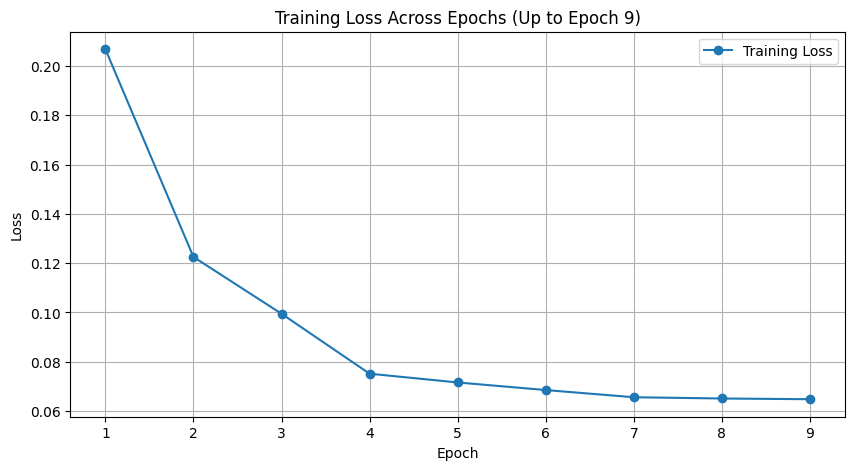

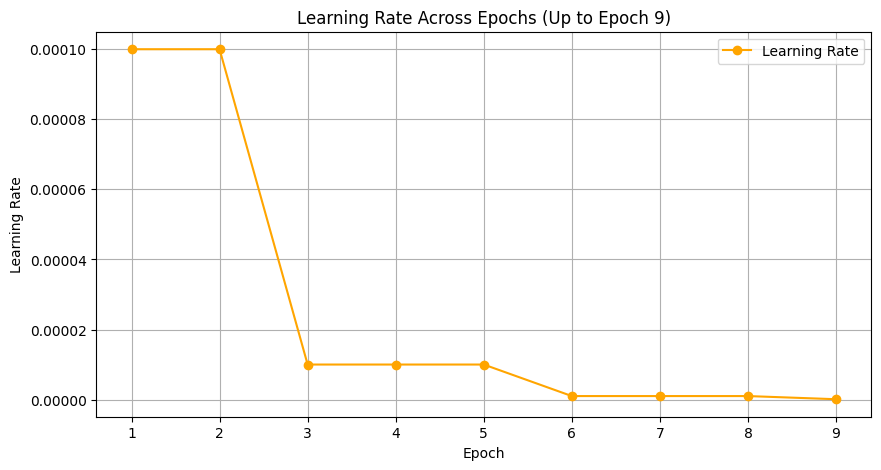

In [14]:
import os
import torch
import matplotlib.pyplot as plt

# Directory where checkpoints are stored
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'

# Initialize lists to store metrics
epochs = []
train_losses = []
learning_rates = []

# Check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load metrics from checkpoints (up to epoch 9)
for file in sorted(os.listdir(checkpoint_dir)):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        checkpoint_path = os.path.join(checkpoint_dir, file)
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Extract epoch
        epoch = checkpoint['epoch']
        if epoch > 9:  # Skip epochs beyond 9
            continue

        # Append metrics
        epochs.append(epoch)
        train_losses.append(checkpoint['train_loss'])

        # Extract optimizer state for learning rate
        optimizer_state = checkpoint['optimizer_state_dict']
        lr = optimizer_state['param_groups'][0]['lr']
        learning_rates.append(lr)

# Plot training loss across epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs (Up to Epoch 9)')
plt.legend()
plt.grid(True)
plt.show()

# Plot learning rate across epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, learning_rates, marker='o', color='orange', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Across Epochs (Up to Epoch 9)')
plt.legend()
plt.grid(True)
plt.show()


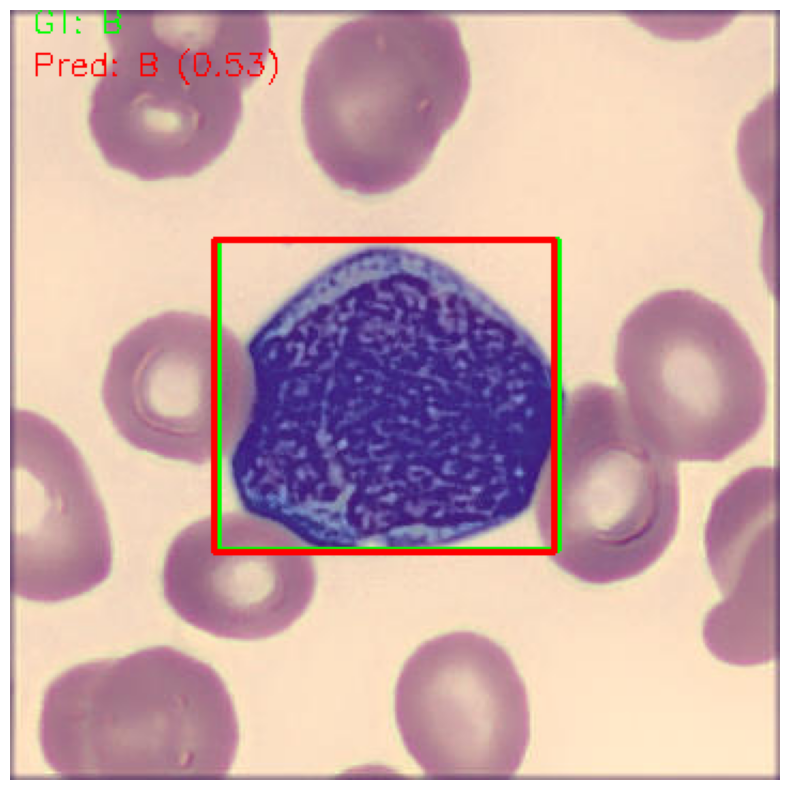

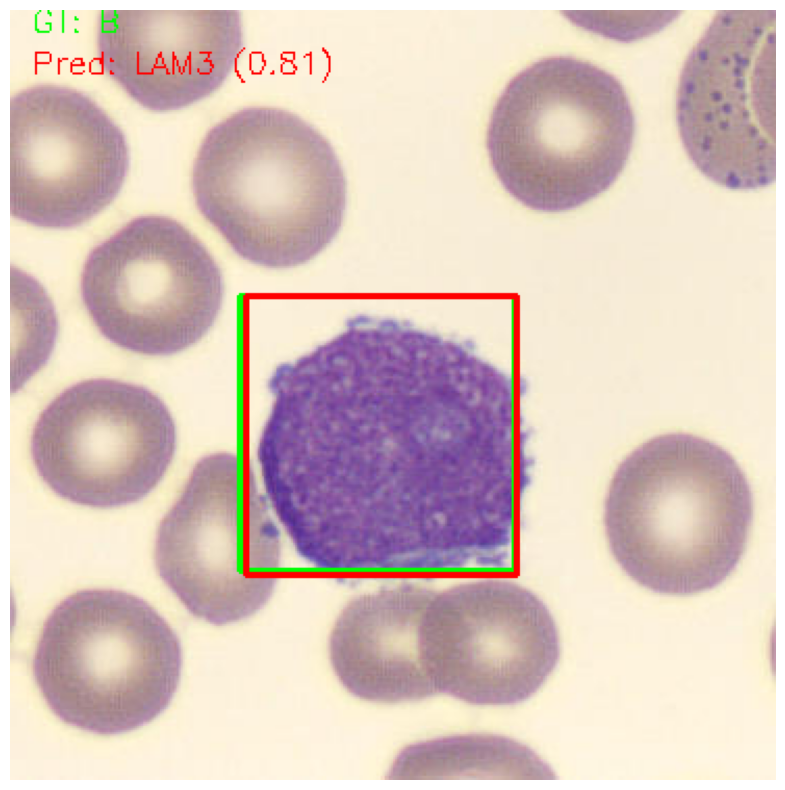

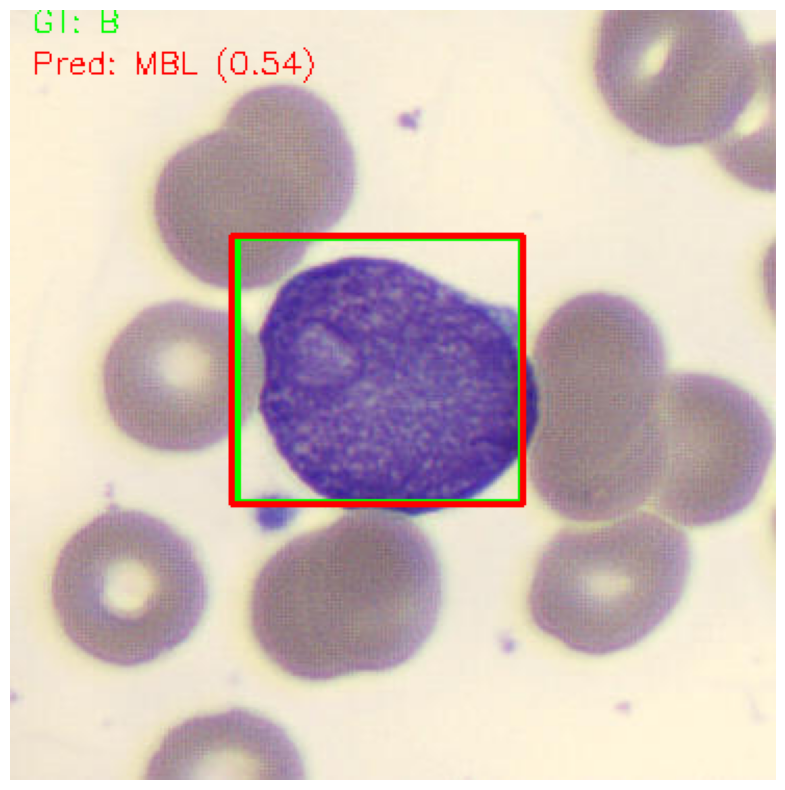

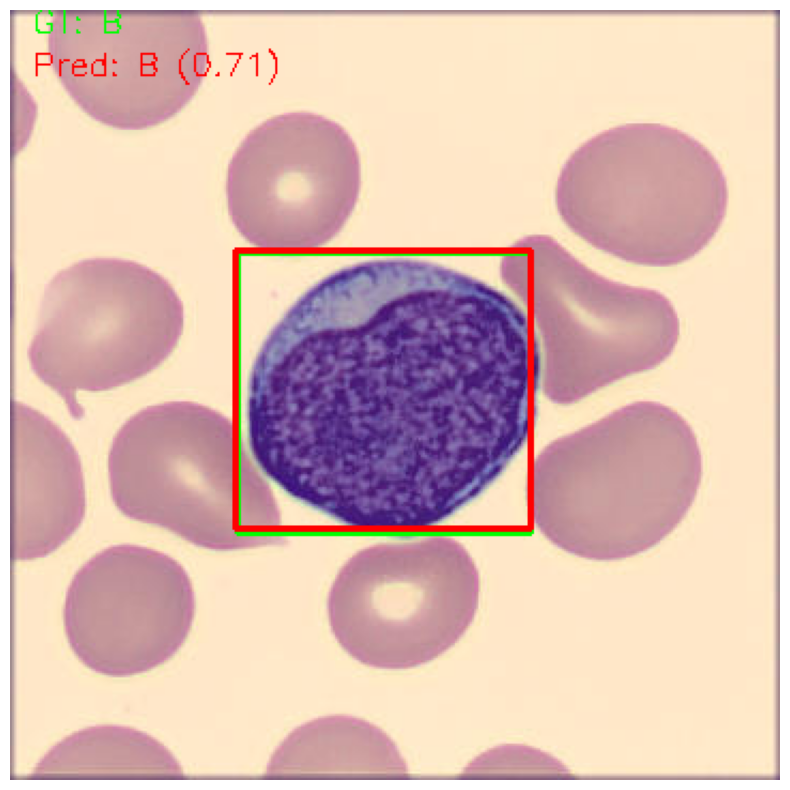

In [13]:
import json
import torch
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load class mappings from COCO JSON
def load_class_mappings(coco_json_path):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)
    categories = coco_data['categories']
    class_names = {category['id']: category['name'] for category in categories}
    return dict(sorted(class_names.items()))  # Sorted by ID

# Function to visualize predictions vs. ground truth
def visualize_predictions_vs_gt(image, target, prediction, class_names):
    # Convert image tensor to NumPy array
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 255).astype(np.uint8)

    # Prepare to draw
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Draw ground truth boxes (Green)
    gt_boxes = target['boxes'].cpu().numpy()
    gt_labels = target['labels'].cpu().numpy()
    for box, label in zip(gt_boxes, gt_labels):
        label_name = class_names.get(int(label), "Unknown")
        cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)

    # Draw predicted boxes (Red)
    pred_boxes = prediction['boxes'].cpu().detach().numpy()
    pred_labels = prediction['labels'].cpu().detach().numpy()
    pred_scores = prediction['scores'].cpu().detach().numpy()
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score > 0.5:  # Confidence threshold
            label_name = class_names.get(int(label), "Unknown")
            cv2.rectangle(image_np, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)

    # Add labels in the top-left corner
    for idx, (label, score) in enumerate(zip(pred_labels, pred_scores)):
        if score > 0.5:
            label_name = class_names.get(int(label), "Unknown")
            text = f"Pred: {label_name} ({score:.2f})"
            y_offset = 30 + (idx * 20)  # Offset each label vertically
            cv2.putText(image_np, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    for idx, label in enumerate(gt_labels):
        label_name = class_names.get(int(label), "Unknown")
        text = f"GT: {label_name}"
        y_offset = 10 + (idx * 20)  # Offset each label vertically
        cv2.putText(image_np, text, (10, y_offset), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Convert image back to RGB for display
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)

    # Display image
    plt.figure(figsize=(10, 10))
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

# Load a batch of test data and visualize
def visualize_sample_predictions(test_loader, model, class_names, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for idx, (images, targets) in enumerate(test_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i in range(min(num_samples, len(images))):
                visualize_predictions_vs_gt(images[i], targets[i], outputs[i], class_names)
            break  # Visualize only one batch


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load class mappings
class_mappings = load_class_mappings(train_output_path)

# Visualize predictions
visualize_sample_predictions(test_loader, model, class_mappings, device)


<ipython-input-16-ddf4bce25c56>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


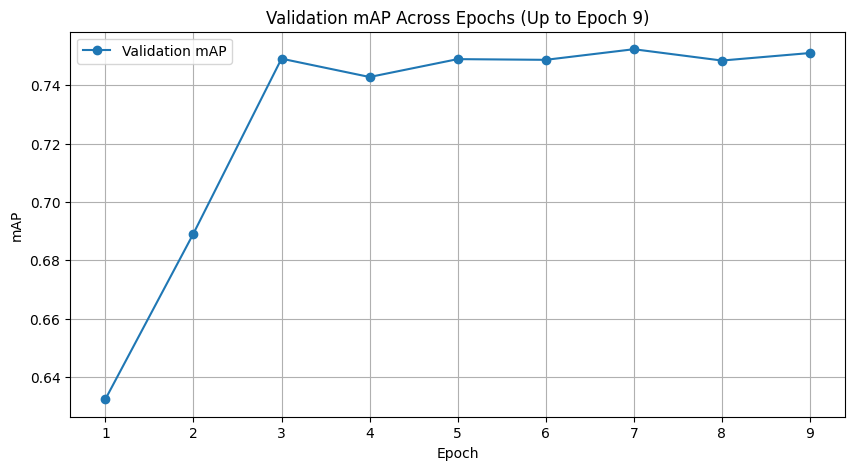

In [16]:
import os
import torch
import matplotlib.pyplot as plt

# Directory where checkpoints are stored
checkpoint_dir = '/content/drive/MyDrive/new_machine/checkpoints_new'

# Initialize lists to store epochs and mAP values
epochs = []
mAP_values = []

# Check device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load mAP values from checkpoints
for file in sorted(os.listdir(checkpoint_dir)):
    if file.startswith('faster_rcnn_epoch') and file.endswith('.pth'):
        checkpoint_path = os.path.join(checkpoint_dir, file)
        checkpoint = torch.load(checkpoint_path, map_location=device)

        epoch = checkpoint['epoch']
        mAP = checkpoint['val_mAP']  # Ensure this key exists in your saved checkpoint

        # Append data up to epoch 9
        if epoch <= 9:
            epochs.append(epoch)
            mAP_values.append(mAP)

# Plot mAP values across epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_values, marker='o', label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP Across Epochs (Up to Epoch 9)')
plt.legend()
plt.grid(True)
plt.show()
